In [1]:
import numpy as np
import pandas as pd
import scipy

from IPython.display import clear_output

import sys
sys.path.append('../../../../Documents/GitHub/gustav/src/')

from gustav import ebi, ncbi, nlm, biogrid, nih
from gustav import publications
from gustav import github
from gustav import access_framework
from gustav import mapper

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append('../general/src/')
from manuscript import export
from manuscript import inout
from manuscript import datasets
from manuscript import tools

from sklearn.metrics import auc
from scipy.stats import fisher_exact
pd.options.display.precision = 3
pd.options.display.expand_frame_repr = False
pd.options.display.max_columns = 20

In [2]:
taxon = 9606
gene_flavor = 'ou'
ref_genes = datasets.reference_genes(taxon, gene_flavor)
gene_info = ncbi.gene_info(taxon, mode='unambiguous_ensembl')

C:\Users\richa\Documents\GitHub\promising_genes\notebooks\../../../../Documents/GitHub/gustav/src\gustav\utils.py:52: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df_with_delimiter.drop(column, 1).reset_index(),
C:\Users\richa\Documents\GitHub\promising_genes\notebooks\../../../../Documents/GitHub/gustav/src\gustav\utils.py:63: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  joined = joined.drop('helper_index', 1)
C:\Users\richa\Documents\GitHub\promising_genes\notebooks\../../../../Documents/GitHub/gustav/src\gustav\utils.py:52: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df_with_delimiter.drop(column, 1).reset_index(),
C:\Users\richa\Documents\GitHub\promising_genes\notebooks\../../../../Documents/GitHub/gustav/src\gustav\u

In [3]:
ref_literature = datasets.reference_publications(taxon)

In [4]:
agg = []
literature_flavor = 'pubtator_title_or_abstract_in_any_gene2pubmed_paper'

gene2lit = datasets.reference_gene2lit(
    taxon, 
    literature_flavor)
gene2lit = gene2lit[
    gene2lit['gene_ncbi'].isin(ref_genes) & 
    gene2lit['pubmed_id'].isin(ref_literature)
].copy()

In [5]:
%%time
gene2pubmed = gene2lit #ncbi.gene2pubmed(taxon_ncbi=9606)
large_pubs = gene2pubmed['pubmed_id'].value_counts()[gene2pubmed['pubmed_id'].value_counts() >= 100].index.values
#gene2pubmed = gene2pubmed[~gene2pubmed['pubmed_id'].isin(large_pubs)]

gene2pubmed_dict = gene2pubmed[~gene2pubmed['pubmed_id'].isin(large_pubs)].value_counts('gene_ncbi').to_dict()

CPU times: total: 141 ms
Wall time: 134 ms


# EBI-GWAS

In [27]:
gwas = ebi.gwas(dataset='associations')

In [28]:
gwas['pubmed_id'].value_counts()

35213538    18069
34594039    17797
32888494    16900
30595370    14061
34021172    13546
            ...  
21082022        1
26198393        1
27758888        1
30971808        1
21703177        1
Name: pubmed_id, Length: 5162, dtype: int64

In [29]:
df_array = []

# snp ids
gwas_slice = gwas[gwas['snp_gene_ids'] != None].copy()

gwas_slice['gene_id'] = gwas_slice['snp_gene_ids'].astype(str).str.split(', ')
gwas_slice = gwas_slice.explode('gene_id')
gwas_slice['type'] = 'snp'
df_array.append(gwas_slice)

# downstream ids
gwas_slice = gwas[gwas['downstream_gene_id'] != None]
gwas_slice['gene_id'] = gwas_slice['downstream_gene_id']
gwas_slice['type'] = 'downstream'
df_array.append(gwas_slice)

# upstream ids
gwas_slice = gwas[gwas['upstream_gene_id'] != None]
gwas_slice['gene_id'] = gwas_slice['upstream_gene_id']
gwas_slice['type'] = 'upstream'
df_array.append(gwas_slice)

gwas = pd.concat(df_array).dropna(subset=['gene_id'])
gwas = gwas[(gwas['gene_id'].astype(str) != "None")]

gwas = pd.merge(gwas, gene_info[['gene_ncbi', 'gene_ensembl']], left_on='gene_id', right_on='gene_ensembl')

In [30]:
gwas['pubmed_id'].value_counts()

35213538    22721
34594039    21592
32888494    19722
34503513    17612
30595370    15661
            ...  
29097723        1
21826085        1
18987618        1
29593015        1
27455349        1
Name: pubmed_id, Length: 4999, dtype: int64

In [31]:
gwas[(gwas['pvalue_mlog'] >= -np.log10(5e-8))]['pubmed_id'].value_counts()

35213538    22721
34594039    21592
32888494    19722
34503513    17612
30595370    14928
            ...  
32895509        1
22452962        1
29453196        1
29059430        1
25758998        1
Name: pubmed_id, Length: 3887, dtype: int64

In [32]:
gwas[(gwas['pvalue_mlog'] >= -np.log10(5e-8)) & (gwas['type'] == 'snp')]['pubmed_id'].value_counts()

34503513    14772
35213538    12476
34594039    12382
32888494    12120
30595370     8862
            ...  
23297363        1
28468790        1
27601451        1
25338677        1
33542107        1
Name: pubmed_id, Length: 3500, dtype: int64

In [16]:
gwas[(gwas['pvalue_mlog'] >= -np.log10(1e-5)) & 
     (gwas['type'] == 'snp') & 
     (gwas['pubmed_id'].isin(gene2pubmed['pubmed_id']))]['pubmed_id'].value_counts()

31761296    337
29124443    112
32581359     67
26414677     45
28754779     41
           ... 
19561606      1
21871595      1
18327257      1
18327256      1
30992453      1
Name: pubmed_id, Length: 651, dtype: int64

In [8]:
gwas_slice = gwas[(gwas['type'] == 'snp') & 
                (gwas['pubmed_id'].isin(gene2pubmed['pubmed_id'])) &
                (gwas['pvalue_mlog'] >= -np.log10(5e-8))].copy()

In [9]:
gwas_slice['pubmed_id'].drop_duplicates().to_csv('../data/gwas_pubmed_ids.csv', index=False)

In [187]:
%%time
icite = nih.icite(dataset='citations')

CPU times: total: 20.8 s
Wall time: 23.5 s


In [80]:
(
gwas[(gwas['type'] == 'snp') & 
     (gwas['pubmed_id'].isin(gene2pubmed['pubmed_id']))]
.drop_duplicates(['gene_ncbi', 'pubmed_id'])['gene_ncbi'].value_counts()
)

2646         20
100048912    19
28           15
79068        15
10452        14
             ..
56142         1
56137         1
56136         1
56147         1
5630          1
Name: gene_ncbi, Length: 2991, dtype: int64

In [10]:
gwas

,date added to catalog,pubmed_id,first author,date,journal,link,study,disease/trait,initial sample size,replication sample size,...,pvalue_mlog,p-value (text),or or beta,95% ci (text),platform [snps passing qc],cnv,gene_id,type,gene_ncbi,gene_ensembl
0,2009-12-14,19915573,Asano K,2009-11-15,Nat Genet,www.ncbi.nlm.nih.gov/pubmed/19915573,A genome-wide association study identifies thr...,Ulcerative colitis,"376 Japanese ancestry cases, 934 Japanese ance...","376 Japanese ancestry cases, 1,097 Japanese an...",...,11.699,None,1.590,[1.39-1.82],Illumina [513923],N,ENSG00000143226,snp,2212,ENSG00000143226
1,2013-09-26,23652523,Mayerle J,2013-05-08,JAMA,www.ncbi.nlm.nih.gov/pubmed/23652523,Identification of genetic loci associated with...,Helicobacter pylori serologic status,"2,623 European ancestry high titer cases, 7,86...",None,...,7.699,None,1.370,[1.23-1.54],"Affymetrix, Illumina [~ 2500000] (imputed)",N,ENSG00000143226,snp,2212,ENSG00000143226
2,2011-03-29,21297633,Anderson CA,2011-02-06,Nat Genet,www.ncbi.nlm.nih.gov/pubmed/21297633,Meta-analysis identifies 29 additional ulcerat...,Ulcerative colitis,"6,687 European ancestry cases, 19,718 European...","9,628 European ancestry cases, 12,917 European...",...,19.699,None,1.210,[1.16-1.26],"Affymetrix, Illumina [~ 1100000] (imputed)",N,ENSG00000143226,snp,2212,ENSG00000143226
3,2020-06-17,32327693,Oskarsson GR,2020-04-23,Commun Biol,www.ncbi.nlm.nih.gov/pubmed/32327693,Predicted loss and gain of function mutations ...,Hemoglobin levels,"684,122 European ancestry individuals",None,...,20.155,None,0.031,[NR] unit increase,"Affymetrix, Illumina [43000000] (imputed)",N,ENSG00000143226,snp,2212,ENSG00000143226
4,2018-04-25,23749187,Cortes A,2013-07-01,Nat Genet,www.ncbi.nlm.nih.gov/pubmed/23749187,Identification of multiple risk variants for a...,Ankylosing spondylitis,"9,069 European ancestry cases, 1,550 East Asia...",None,...,9.000,(EA),1.120,None,Illumina [128935],N,ENSG00000143226,snp,2212,ENSG00000143226
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
435507,2021-12-14,34594039,Sakaue S,2021-09-30,Nat Genet,www.ncbi.nlm.nih.gov/pubmed/34594039,A cross-population atlas of genetic associatio...,Serum total protein level,"314,921 European ancestry individuals, 133,321...",None,...,8.046,None,0.015,[0.0097-0.0199] unit increase,"Affymetrix, Illumina [20536782] (imputed)",N,ENSG00000153044,upstream,64946,ENSG00000153044
435508,2022-07-25,34077760,Alipanahi B,2021-06-01,Am J Hum Genet,www.ncbi.nlm.nih.gov/pubmed/34077760,Large-scale machine-learning-based phenotyping...,Vertical cup-disc ratio,"65,680 European ancestry individuals",None,...,15.046,None,0.006,[0.0043-0.0071] unit increase,Affymetrix [13110443] (imputed),N,ENSG00000251893,upstream,124900321,ENSG00000251893
435509,2022-07-25,34077760,Alipanahi B,2021-06-01,Am J Hum Genet,www.ncbi.nlm.nih.gov/pubmed/34077760,Large-scale machine-learning-based phenotyping...,Vertical cup-disc ratio,"89,579 European ancestry individuals",None,...,13.398,None,0.043,[0.032-0.053] unit increase,Affymetrix [8600000] (imputed),N,ENSG00000251893,upstream,124900321,ENSG00000251893
435510,2022-07-25,34077760,Alipanahi B,2021-06-01,Am J Hum Genet,www.ncbi.nlm.nih.gov/pubmed/34077760,Large-scale machine-learning-based phenotyping...,Vertical cup-disc ratio,"89,579 European ancestry individuals",None,...,9.000,None,0.038,[0.025-0.052] unit decrease,Affymetrix [8600000] (imputed),N,ENSG00000268812,upstream,91370,ENSG00000268812


In [197]:
def get_genes(gwas, pval_thresh = 5e-8):
    # apply filters and p-value threshold here
    gwas = gwas[(gwas['type'] == 'snp') & 
                (gwas['pubmed_id'].isin(gene2pubmed['pubmed_id'])) &
                (gwas['pvalue_mlog'] >= -np.log10(pval_thresh))].copy()
    
    print(str(len(set(gwas['pubmed_id'].values))) + ' GWAS articles')

    de_dict = gwas.groupby('pubmed_id')['gene_ncbi'].apply(set).to_dict()
    de_dict_mentioned_genes = (
        gene2pubmed[gene2pubmed['pubmed_id']
                    .isin(gwas['pubmed_id'])]
        .groupby('pubmed_id')['gene_ncbi']
        .apply(set).to_dict()
    )

    np.random.seed(49)
    n_samp = 100
    de_sets = []
    de_mentioned_sets = []
    de_mentioned_sets_null = []
    de_citations_mentioned_sets = []
    citations_mentioned_sets = []
    for comparison_key in np.unique(gwas['pubmed_id'].values):
        de_list = de_dict.get(comparison_key)

        if de_dict_mentioned_genes.get(comparison_key):
            de_list_mentioned_genes = de_dict_mentioned_genes.get(comparison_key)
        else:
            de_list_mentioned_genes = set()

        for n_n in range(n_samp):
            de_mentioned_sets_null.append(set(np.random.choice(list(de_list), 
                                                               replace=False, size=len(de_list_mentioned_genes & de_list))))

        de_sets.append(de_list)
        de_mentioned_sets.append(de_list_mentioned_genes)
    de_list_mentioned_genes_null = set().union(*de_mentioned_sets_null)

    icite_slice = icite[icite['referenced'].isin(gwas['pubmed_id'])].copy()

    icite_slice = pd.merge(icite_slice, gene2pubmed, left_on='citing', right_on='pubmed_id')

    icite_slice = pd.merge(gwas[['gene_ncbi', 'pubmed_id']].drop_duplicates(), 
                     icite_slice, 
                     left_on='pubmed_id', right_on='referenced')

    icite_slice = icite_slice[icite_slice['gene_ncbi_x'] == icite_slice['gene_ncbi_y']]

    fig = plt.figure(figsize=(8,5))
    ax = plt.gca()
    pad = 0.2

    prot_genes = set(gene_info[gene_info['type_of_gene'] == 'protein-coding']['gene_ncbi'])

    de_list = set(gwas['gene_ncbi']) & prot_genes #.union(*de_sets) & prot_genes
    de_list_mentioned_genes = de_list & set(gene2pubmed[gene2pubmed['pubmed_id'].isin(gwas['pubmed_id'])]['gene_ncbi']) & prot_genes
    de_list_mentioned_genes_null = set().union(*de_mentioned_sets_null) & prot_genes
    de_citations_mentioned_sets = de_list & set(icite_slice['gene_ncbi_y'])
    #itations_mentioned_sets = set().union(*citations_mentioned_sets) & prot_genes
    medianprops = dict(linestyle='solid', linewidth=2, color='k')
    whiskerprops = dict(linestyle='solid', linewidth=2, color='k')
    capprops = dict(linestyle='solid', linewidth=2, color='k')

    data = [(pd.DataFrame([gene2pubmed_dict.get(x) for x in prot_genes]).fillna(0.0) + 1)[0].values,
            (pd.DataFrame([gene2pubmed_dict.get(x) for x in de_list]).fillna(0.0) + 1)[0].values,
            (pd.DataFrame([gene2pubmed_dict.get(x) for x in de_list_mentioned_genes_null]).fillna(0.0) + 1)[0].values,
           (pd.DataFrame([gene2pubmed_dict.get(x) for x in de_list_mentioned_genes]).fillna(0.0) + 1)[0].values, 
            (pd.DataFrame([gene2pubmed_dict.get(x) for x in de_citations_mentioned_sets]).fillna(0.0) + 1)[0].values]

    ax.boxplot(data, widths=2*pad-(pad/4), positions=np.arange(len(data))+1, whis=[2.5,97.5], patch_artist=True,
               boxprops=dict(facecolor=sns.color_palette()[0], linewidth=2), 
               whiskerprops=whiskerprops, capprops=capprops, medianprops=medianprops)

    ax.set_xlim([1-2.5*pad, 5+2.5*pad])
    ax.set_yscale('log')
    ax.set_xticks([1,2,3,4,5], labels=['all protein-\ncoding genes',
                                     'GWAS hits', 
                                     'null expectation',
                                   'GWAS hits\npromoted to\ntitle/abstract', 
                                   'GWAS hits\npromoted to\ntitle/abstract\nin citing papers'])

    df_array = []
    for gene_set, label in zip([prot_genes, 
                de_list, 
                de_list_mentioned_genes_null, 
                de_list_mentioned_genes, 
                de_citations_mentioned_sets],
                       ['genome', 
                        'hits', 
                        'mentioned_hits_null',
                        'mentioned_hits', 
                        'citations_mentioned_hits']):
        temp_df = pd.DataFrame({'gene_ncbi':list(gene_set)})
        temp_df['set'] = label
        df_array.append(temp_df)
    temp_df = pd.concat(df_array)

    temp_df.to_csv('../data/gwas_hits_' + str(pval_thresh) + '.csv', index=False)

800 GWAS articles
651 GWAS articles
568 GWAS articles
475 GWAS articles
421 GWAS articles


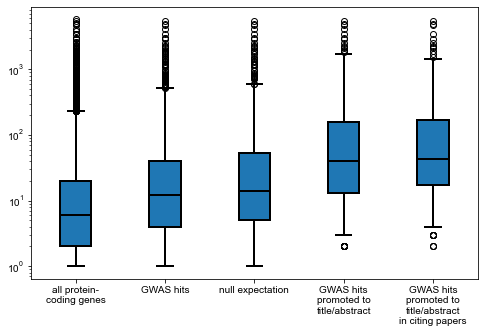

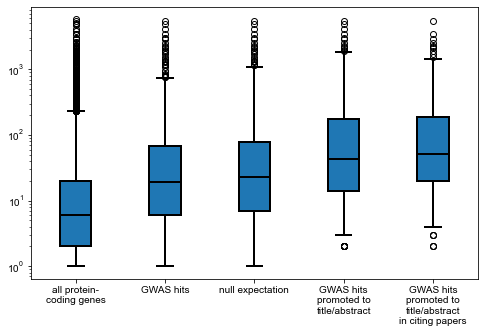

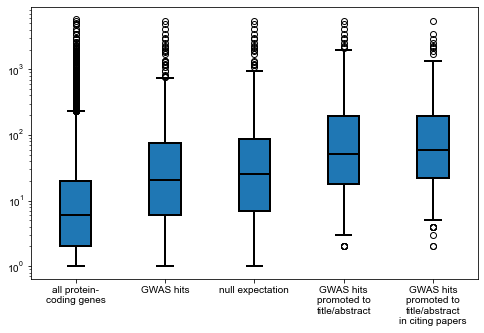

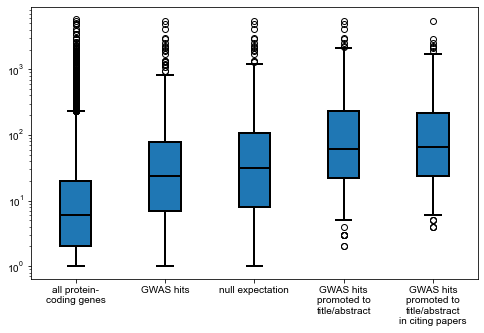

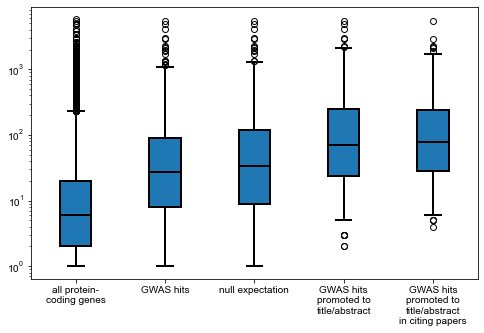

In [198]:
get_genes(gwas, pval_thresh=1e-5)
get_genes(gwas, pval_thresh=5e-8)
get_genes(gwas, pval_thresh=1e-8)
get_genes(gwas, pval_thresh=1e-9)
get_genes(gwas, pval_thresh=1e-10)

# Scraps below

In [173]:
# apply filters and p-value threshold here
gwas = gwas[(gwas['type'] == 'snp') & 
            (gwas['pubmed_id'].isin(gene2pubmed['pubmed_id'])) &
            (gwas['pvalue_mlog'] > 10)]

In [174]:
de_dict = gwas.groupby('pubmed_id')['gene_ncbi'].apply(set).to_dict()
de_dict_mentioned_genes = (
    gene2pubmed[gene2pubmed['pubmed_id']
                .isin(gwas['pubmed_id'])]
    .groupby('pubmed_id')['gene_ncbi']
    .apply(set).to_dict()
)

In [175]:
np.random.seed(49)
n_samp = 100
de_sets = []
de_mentioned_sets = []
de_mentioned_sets_null = []
de_citations_mentioned_sets = []
citations_mentioned_sets = []
for comparison_key in np.unique(gwas['pubmed_id'].values):
    de_list = de_dict.get(comparison_key)
    
    if de_dict_mentioned_genes.get(comparison_key):
        de_list_mentioned_genes = de_dict_mentioned_genes.get(comparison_key)
    else:
        de_list_mentioned_genes = set()
        
    for n_n in range(n_samp):
        de_mentioned_sets_null.append(set(np.random.choice(list(de_list), 
                                                           replace=False, size=len(de_list_mentioned_genes & de_list))))
        
    de_sets.append(de_list)
    de_mentioned_sets.append(de_list_mentioned_genes)
de_list_mentioned_genes_null = set().union(*de_mentioned_sets_null)

In [177]:
icite_slice = icite[icite['referenced'].isin(gwas['pubmed_id'])].copy()

CPU times: total: 4.66 s
Wall time: 4.65 s


In [178]:
icite_slice = pd.merge(icite_slice, gene2pubmed, left_on='citing', right_on='pubmed_id')

CPU times: total: 62.5 ms
Wall time: 67.1 ms


In [179]:
icite_slice = pd.merge(gwas[['gene_ncbi', 'pubmed_id']].drop_duplicates(), 
                 icite_slice, 
                 left_on='pubmed_id', right_on='referenced')

In [180]:
icite_slice = icite_slice[icite_slice['gene_ncbi_x'] == icite_slice['gene_ncbi_y']]

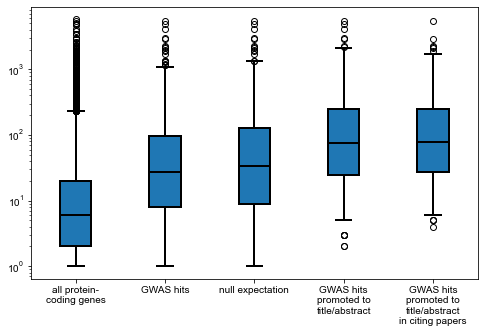

In [181]:
fig = plt.figure(figsize=(8,5))
ax = plt.gca()
pad = 0.2

prot_genes = set(gene_info[gene_info['type_of_gene'] == 'protein-coding']['gene_ncbi'])

de_list = set(gwas['gene_ncbi']) & prot_genes #.union(*de_sets) & prot_genes
de_list_mentioned_genes = de_list & set(gene2pubmed[gene2pubmed['pubmed_id'].isin(gwas['pubmed_id'])]['gene_ncbi']) & prot_genes
de_list_mentioned_genes_null = set().union(*de_mentioned_sets_null) & prot_genes
de_citations_mentioned_sets = de_list & set(icite['gene_ncbi_y'])
#itations_mentioned_sets = set().union(*citations_mentioned_sets) & prot_genes
medianprops = dict(linestyle='solid', linewidth=2, color='k')
whiskerprops = dict(linestyle='solid', linewidth=2, color='k')
capprops = dict(linestyle='solid', linewidth=2, color='k')

data = [(pd.DataFrame([gene2pubmed_dict.get(x) for x in prot_genes]).fillna(0.0) + 1)[0].values,
        (pd.DataFrame([gene2pubmed_dict.get(x) for x in de_list]).fillna(0.0) + 1)[0].values,
        (pd.DataFrame([gene2pubmed_dict.get(x) for x in de_list_mentioned_genes_null]).fillna(0.0) + 1)[0].values,
       (pd.DataFrame([gene2pubmed_dict.get(x) for x in de_list_mentioned_genes]).fillna(0.0) + 1)[0].values, 
        (pd.DataFrame([gene2pubmed_dict.get(x) for x in de_citations_mentioned_sets]).fillna(0.0) + 1)[0].values]

ax.boxplot(data, widths=2*pad-(pad/4), positions=np.arange(len(data))+1, whis=[2.5,97.5], patch_artist=True,
           boxprops=dict(facecolor=sns.color_palette()[0], linewidth=2), 
           whiskerprops=whiskerprops, capprops=capprops, medianprops=medianprops)

ax.set_xlim([1-2.5*pad, 5+2.5*pad])
ax.set_yscale('log')
ax.set_xticks([1,2,3,4,5], labels=['all protein-\ncoding genes',
                                 'GWAS hits', 
                                 'null expectation',
                               'GWAS hits\npromoted to\ntitle/abstract', 
                               'GWAS hits\npromoted to\ntitle/abstract\nin citing papers'])

In [162]:
df_array = []
for gene_set, label in zip([prot_genes, 
            de_list, 
            de_list_mentioned_genes_null, 
            de_list_mentioned_genes, 
            de_citations_mentioned_sets],
                   ['genome', 
                    'hits', 
                    'mentioned_hits_null',
                    'mentioned_hits', 
                    'citations_mentioned_hits']):
    temp_df = pd.DataFrame({'gene_ncbi':list(gene_set)})
    temp_df['set'] = label
    df_array.append(temp_df)
temp_df = pd.concat(df_array)

temp_df.to_csv('../data/gwas_hits_221015.csv', index=False)

In [171]:
scipy.stats.mannwhitneyu(data[0], data[1])

MannwhitneyuResult(statistic=7835763.5, pvalue=5.600518443833819e-109)